# Benchmarking

This notebook benchmarks 5 algorithms on a ASC dataset for constrained neural networks training and is divided as follows: 

1. Unconstrained Optimization Adam
2. SSL-ALM
3. Switching Subgradient 
4. [Cooper](https://github.com/cooper-org/cooper?tab=readme-ov-file)
5. [CHOP](https://github.com/openopt/chop)

-------------------------------------------------------------------------



In [7]:
# define the torch seed here
seed_n = 1
n_epochs = 60

# log path file
log_path = "./data/logs/log_benchmark.npz"

# Deterministic constraints: 

#### 1. Unconstrained Optimization

Mainly for setting a reference bar

In [8]:
# load and prepare data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
from folktables import ACSDataSource, ACSIncome, generate_categories

# load folktables data
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["VA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncome.features, definition_df=definition_df)
df_feat, df_labels, _ = ACSIncome.df_to_pandas(acs_data,categories=categories, dummies=True)

In [9]:
sens_cols = ['SEX_Female', 'SEX_Male']
features = df_feat.drop(columns=sens_cols).to_numpy(dtype="float")
groups = df_feat[sens_cols].to_numpy(dtype="float")
labels = df_labels.to_numpy(dtype="float")

print(sens_cols)
print(features.shape)
print(groups.shape)
print(labels.shape)

['SEX_Female', 'SEX_Male']
(46144, 800)
(46144, 2)
(46144, 1)


In [10]:
# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    features, labels, groups, test_size=0.2, random_state=42)

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# make into a pytorch dataset, remove the sensitive attribute
features_train = torch.tensor(X_train, dtype=torch.float32)
labels_train = torch.tensor(y_train,dtype=torch.float32)
sens_train = torch.tensor(groups_train)
dataset_train = torch.utils.data.TensorDataset(features_train, labels_train)

In [11]:
import torch
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# create the SSLALM optimizer
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

# bounds for the constraints: norm of each weight matrix should be <= 1
constraint_bounds = [1.]*m

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [12]:
# alloc arrays for plotting
Adam_loss_log_plotting = []
Adam_c_log_plotting    = []
Adam_std_loss_log_plotting = []
Adam_std_c_log_plotting = []

# training loop
for epoch in range(n_epochs):
    
    # alloc the logging arrays
    loss_log = []
    c_log = []

    # go through all data
    for batch_input, batch_label in dataloader:
        
        # calculate constraints - just for logging since this is an unconstrainted optimization
        c_log.append([])
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # convert constraint to equality
            norm_viol = torch.max(
                norm 
                - constraint_bounds[i],
                torch.zeros(1)
            )   

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()

        # save the loss and the dual variables
        loss_log.append(loss.detach().numpy())
        
        # update the primal variables together with smoothing dual variable
        optimizer.step()
        optimizer.zero_grad()
    
    # save the epoch values for plotting
    Adam_loss_log_plotting.append(np.mean(loss_log))
    Adam_c_log_plotting.append(np.mean(c_log, axis=0))
    Adam_std_loss_log_plotting.append(np.std(loss_log))
    Adam_std_c_log_plotting.append(np.std(c_log, axis=0))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

Epoch: 0, loss: 0.45870882272720337, constraints: [4.892406   0.31928727 1.5516857  0.4506065  0.71107453 0.13503225], 
Epoch: 1, loss: 0.39446115493774414, constraints: [5.518849   0.3471279  1.6876335  0.46916848 0.7312506  0.13287035], 
Epoch: 2, loss: 0.38164374232292175, constraints: [5.6150737  0.34900537 1.7455273  0.47634044 0.749155   0.12971953], 
Epoch: 3, loss: 0.37222227454185486, constraints: [5.523676   0.35618073 1.8139473  0.4795078  0.7742632  0.12869503], 
Epoch: 4, loss: 0.36324581503868103, constraints: [5.449283   0.39863068 1.9029832  0.4857641  0.82546806 0.12741107], 
Epoch: 5, loss: 0.3523440361022949, constraints: [5.367149   0.46442527 2.02457    0.5056905  0.90122485 0.12718181], 
Epoch: 6, loss: 0.34078747034072876, constraints: [5.3218727 0.5499805 2.1359143 0.5236355 0.9999457 0.1262185], 
Epoch: 7, loss: 0.3291148543357849, constraints: [5.2538085  0.6464523  2.2500186  0.55353206 1.1046134  0.12528859], 
Epoch: 8, loss: 0.3169771730899811, constraints:

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def plot_losses_and_constraints_multi(
    losses_list,
    constraints_list,
    constraint_thresholds,
    losses_std_list=None,
    titles=None,
    plot_individual_constraints=True,
    eval_points=2,
    std_multiplier=2,
):
    """
    Plot loss and constraint values for multiple ML algorithms with min-max, std, and eval points.

    Parameters
    ----------
    losses_list : list of np.ndarray or list of 2D np.ndarray
        Each element is either:
        - 1D array of losses for one algorithm, or
        - 2D array (num_runs x timesteps) for multiple runs.
    constraints_list : list of list of np.ndarray
        Each element is a list of 1D arrays (constraint values for that algorithm).
    constraint_thresholds : np.ndarray or list
        Threshold lines for constraints.
    losses_std_list : list of np.ndarray, optional
        1D array of std per algorithm.
    titles : list of str, optional
        Algorithm names.
    plot_individual_constraints : bool, default True
        Plot individual constraint curves.
    eval_points : int or array-like, default 2
        Epoch indices to mark with symbols.
    std_multiplier : float, default 2
        Multiplier for shading std bands.
    """
    # --- Color palette: Tableau 10 ---
    colors = [
        "#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F",
        "#EDC948", "#B07AA1", "#FF9DA7", "#9C755F", "#BAB0AB"
    ]
    # --- Marker styles ---
    marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', 'P', 'X', '*']
    
    num_algos = len(losses_list)
    if titles is None:
        titles = [f"Algorithm {i+1}" for i in range(num_algos)]
    constraint_thresholds = np.atleast_1d(constraint_thresholds)

    fig, axes = plt.subplots(2, num_algos, figsize=(5*num_algos, 8), sharex='col')
    if num_algos == 1:
        axes = np.array([[axes[0]], [axes[1]]])  # consistent 2D indexing

    for j in range(num_algos):
        loss = np.asarray(losses_list[j])
        x = np.arange(loss.shape[-1])
        color = colors[j % len(colors)]

        # --- LOSS PLOT ---
        ax_loss = axes[0, j]
        # Multiple runs: min-max shading
        if loss.ndim == 2:
            loss_mean = np.mean(loss, axis=0)
            loss_min = np.min(loss, axis=0)
            loss_max = np.max(loss, axis=0)
            ax_loss.fill_between(x, loss_min, loss_max, color=color, alpha=0.15, label='Mean Loss +- Std')
        else:
            loss_mean = loss

        # Std shading
        if losses_std_list is not None and losses_std_list[j] is not None:
            loss_std = np.asarray(losses_std_list[j])
            ax_loss.fill_between(x, loss_mean - std_multiplier*loss_std,
                                 loss_mean + std_multiplier*loss_std,
                                 color=color, alpha=0.25, label=f'Loss ± Std')

        # Mean curve
        ax_loss.plot(x, loss_mean, color=color, lw=2, label=titles[j])

        # Eval points
        if eval_points is not None:
            if isinstance(eval_points, int):
                idx = np.arange(0, len(loss_mean), eval_points)
            else:
                idx = np.array(eval_points)
                idx = idx[idx < len(loss_mean)]
            ax_loss.plot(x[idx], loss_mean[idx], marker_styles[j], color=color, markersize=6)

        ax_loss.set_title(titles[j])
        ax_loss.set_ylabel("Mean Loss")
        ax_loss.grid(True, linestyle="--", alpha=0.35)
        ax_loss.legend(fontsize=9)

        # --- CONSTRAINT PLOT ---
        ax_constr = axes[1, j]
        constraints = np.array(constraints_list[j])
        x = np.arange(constraints.shape[1])
        color = colors[j % len(colors)]

        # Optional: individual constraint curves
        if plot_individual_constraints:
            for c in constraints:
                ax_constr.plot(x, c, color=color, alpha=0.6, lw=1.5)

        # Min-Max band for constraints
        c_min = np.min(constraints, axis=0)
        c_max = np.max(constraints, axis=0)
        ax_constr.fill_between(x, c_min, c_max, color=color, alpha=0.15, label='Constraint Range')

        # Threshold lines
        for th in constraint_thresholds:
            ax_constr.axhline(th, color="red", linestyle="--", lw=1.4, label="Threshold")

        ax_constr.set_ylabel("Constraint")
        ax_constr.grid(True, linestyle="--", alpha=0.35)
        ax_constr.legend(fontsize=9)

    axes[-1, 0].set_xlabel("Epoch")
    plt.tight_layout()
    plt.show()


In [26]:
# save the computed data
np.savez(log_path, losses=[np.array(Adam_loss_log_plotting)], constraints=[np.array(Adam_c_log_plotting).T], 
                    losses_std=[np.array(Adam_std_loss_log_plotting)])

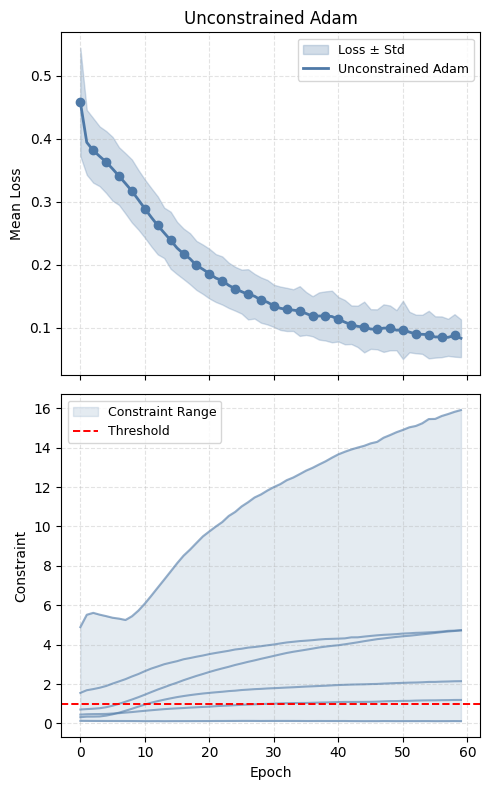

In [33]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
losses_std = np.load(log_path)["losses_std"]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints_multi(losses, constraints, thresholds, losses_std_list=losses_std, 
                            titles=['Unconstrained Adam'], plot_individual_constraints=True, std_multiplier=1)

#### 2.1 SSL-ALM SGD

In [34]:
from humancompatible.train.algorithms import SSLALM

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# create the SSLALM optimizer
optimizer = SSLALM(
    params=model.parameters(),
    m=m,
    lr=0.01,
    dual_lr=0.1
)

# bounds for the constraints: norm of each weight matrix should be <= 1
constraint_bounds = [1.]*m

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [35]:
# alloc arrays for plotting
SSL_ALM_loss_log_plotting = []
SSL_ALM_c_log_plotting    = []
SSL_ALM_std_loss_log_plotting = []

# training loop
for epoch in range(n_epochs):
    
    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []

    # go through all data
    for batch_input, batch_label in dataloader:
        
        # calculate constraints and constraint grads - constraint per each weight matrix
        c_log.append([])
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # convert constraint to equality
            norm_viol = torch.max(
                norm 
                - constraint_bounds[i],
                torch.zeros(1)
            )   

            # calculate the Jacobian of the constraint
            norm_viol.backward()

            # update the dual variable + save the Jacobian for later - its needed in the primal variable update
            optimizer.dual_step(i, c_val=norm_viol)
            optimizer.zero_grad()

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())
        
        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()

        # save the loss and the dual variables
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())
        
        # update the primal variables together with smoothing dual variable
        optimizer.step()
        optimizer.zero_grad()
    
    # save the epoch values for plotting
    SSL_ALM_loss_log_plotting.append(np.mean(loss_log))
    SSL_ALM_c_log_plotting.append(np.mean(c_log, axis=0))
    SSL_ALM_std_loss_log_plotting.append(np.std(loss_log))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.5579718947410583, constraints: [0.91289365 0.24924642 0.98641264 0.46461216 0.8706531  0.0809375 ], dual: [0.15808122 0.         0.15734595 0.         0.18665232 0.        ]
Epoch: 1, loss: 0.4504135251045227, constraints: [0.99983734 0.6695479  0.9999918  0.620562   0.99979573 0.1346861 ], dual: [0.20943607 0.         0.24302068 0.         0.26294106 0.        ]
Epoch: 2, loss: 0.4304836094379425, constraints: [0.9995162  0.9619825  0.999482   0.68241566 0.9993693  0.12400071], dual: [0.24706516 0.02461725 0.29858512 0.         0.31679347 0.        ]
Epoch: 3, loss: 0.4220561981201172, constraints: [0.99928004 0.9998961  0.9991873  0.714672   0.9990925  0.11561225], dual: [0.2747239  0.03297184 0.34435636 0.         0.36106533 0.        ]
Epoch: 4, loss: 0.4155169725418091, constraints: [0.9992754  0.9998498  0.9989219  0.73707056 0.9988016  0.11102299], dual: [0.29876593 0.03830024 0.38133433 0.         0.39619225 0.        ]
Epoch: 5, loss: 0.41038405895233154, con

In [39]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])

# append
losses += [np.array(SSL_ALM_loss_log_plotting)]
constraints += [np.array(SSL_ALM_c_log_plotting).T]
losses_std += [np.array(SSL_ALM_std_loss_log_plotting)]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std)

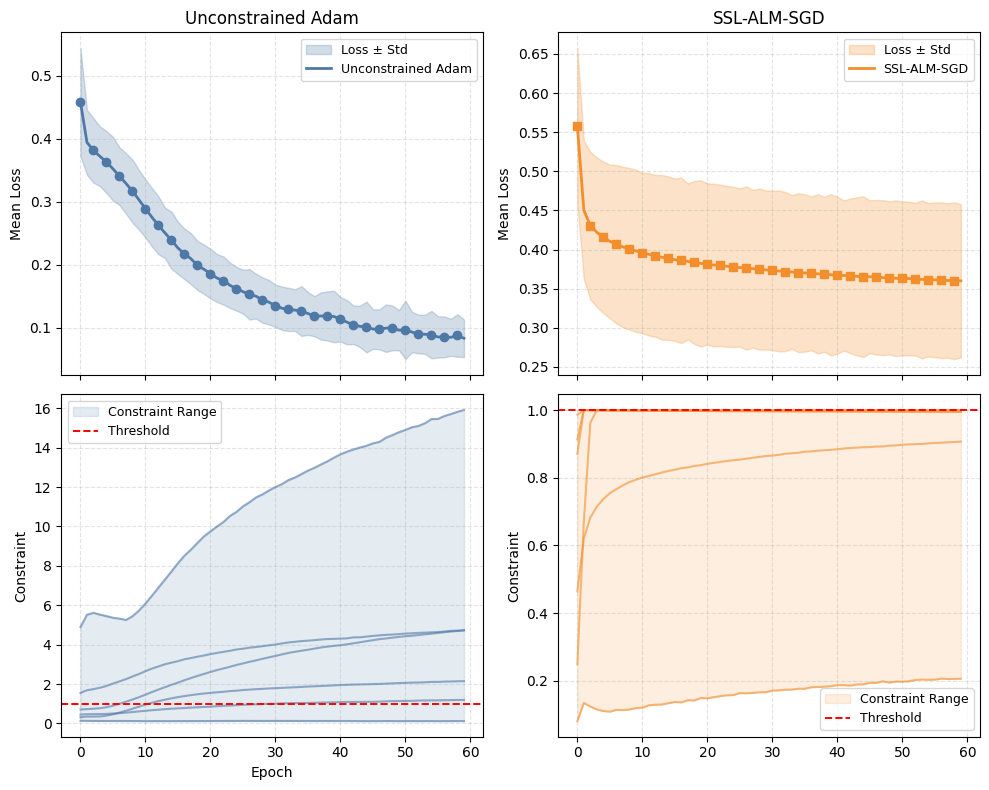

In [40]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
losses_std = np.load(log_path)["losses_std"]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints_multi(losses, constraints, thresholds, losses_std_list=losses_std,  std_multiplier=1,
                                  titles=['Unconstrained Adam', 'SSL-ALM-SGD'], plot_individual_constraints=True)

#### 2.2 SSL-ALM Adam

In [41]:
import sys, os
# Add the ../src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.humancompatible.train.optim.ssl_alm_adam import SSLALM_Adam

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# create the SSLALM optimizer
optimizer = SSLALM_Adam(
    params=model.parameters(),
    m=m,
    lr=0.001,
    dual_lr=0.1
)

# bounds for the constraints: norm of each weight matrix should be <= 1
constraint_bounds = [1.]*m

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [42]:
# alloc arrays for plotting
SSL_ALM_Adam_loss_log_plotting = []
SSL_ALM_Adam_c_log_plotting    = []
SSL_ALM_Adam_std_c_log_plotting    = []

# training loop
for epoch in range(n_epochs):
    
    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []

    # go through all data
    for batch_input, batch_label in dataloader:
        
        # calculate constraints and constraint grads - constraint per each weight matrix
        c_log.append([])
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # convert constraint to equality
            norm_viol = torch.max(
                norm 
                - constraint_bounds[i],
                torch.zeros(1)
            )   

            # calculate the Jacobian of the constraint
            norm_viol.backward()

            # update the dual variable + save the Jacobian for later - its needed in the primal variable update
            optimizer.dual_step(i, c_val=norm_viol[0])
            optimizer.zero_grad()

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())
        
        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()

        # save the loss and the dual variables
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())
        
        # update the primal variables together with smoothing dual variable
        optimizer.step()
        optimizer.zero_grad()
    
    # save the epoch values for plotting
    SSL_ALM_Adam_loss_log_plotting.append(np.mean(loss_log))
    SSL_ALM_Adam_c_log_plotting.append(np.mean(c_log, axis=0))          
    SSL_ALM_Adam_std_c_log_plotting.append(np.std(loss_log))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.47237837314605713, constraints: [0.9925282  0.8578605  0.9960306  0.5817014  0.97313595 0.11154877], dual: [0.22479261 0.03087937 0.26491326 0.         0.18057247 0.        ]
Epoch: 1, loss: 0.4328916370868683, constraints: [0.99981815 0.99883825 0.9945939  0.6752885  0.99872744 0.10275991], dual: [0.29251978 0.03858675 0.32678738 0.         0.20986943 0.        ]
Epoch: 2, loss: 0.42501601576805115, constraints: [0.99958366 0.99906313 0.9945085  0.73531103 0.99886656 0.09978881], dual: [0.35241222 0.04249056 0.3697336  0.         0.23132321 0.        ]
Epoch: 3, loss: 0.4201308786869049, constraints: [0.99940085 0.9990588  0.99555016 0.7894717  0.9989862  0.09556165], dual: [0.40895203 0.04553234 0.40539867 0.         0.2516227  0.        ]
Epoch: 4, loss: 0.41494959592819214, constraints: [0.9991474  0.9991321  0.99546045 0.8449935  0.9989612  0.09300704], dual: [0.4610153  0.04825373 0.43609595 0.         0.26891962 0.        ]
Epoch: 5, loss: 0.41152268648147583, 

In [44]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])

# append
losses += [np.array(SSL_ALM_Adam_loss_log_plotting)]
constraints += [np.array(SSL_ALM_Adam_c_log_plotting).T]
losses_std += [np.array(SSL_ALM_Adam_std_c_log_plotting)]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std)

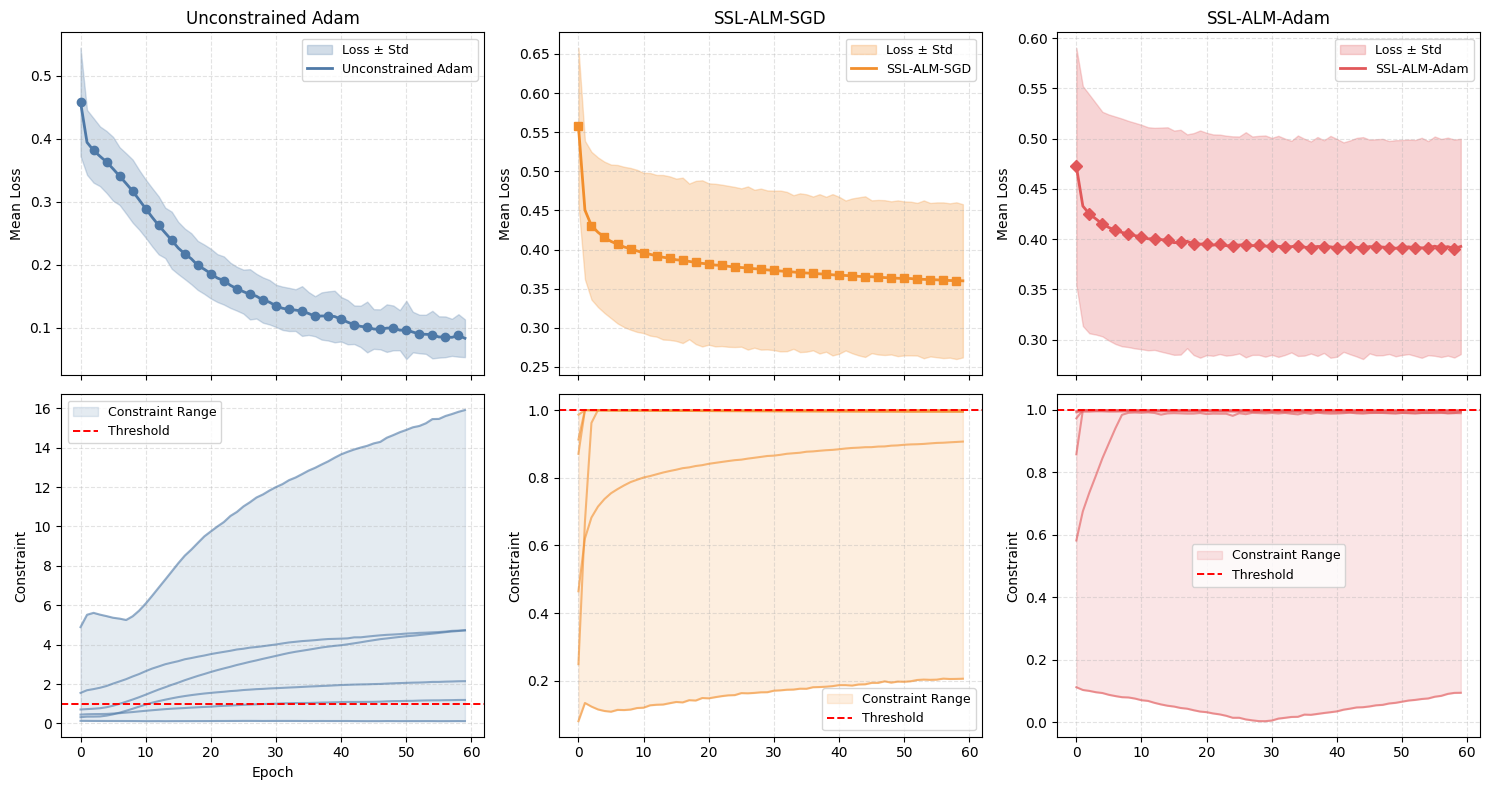

In [45]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
losses_std = np.load(log_path)["losses_std"]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints_multi(losses, constraints, thresholds, losses_std_list=losses_std,  std_multiplier=1,
                                  titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam'], plot_individual_constraints=True)

#### 3. Switching-Subgradient

In [18]:
from humancompatible.train.algorithms import SSG

# set the seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network - same as the other algorithms
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# create the SSLALM optimizer
optimizer = SSG(
    params=model.parameters(),
    m=1,
    lr=0.01,
    dual_lr=0.1
)

# bounds for the constraints: norm of max each weight matrix should be <= 1
constraint_bounds = [1.]

# define epochs + loss function - same loss should be defined for all algorithms
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# alloc the plotting array
SSG_c_log_plotting = []
SSG_loss_log_plotting = []
SSG_std_loss_log_plotting = []

# training loop
for epoch in range(n_epochs):
    
    # alloc logging array
    loss_log = []
    c_log = []
    duals_log = []

    # train for all data
    for batch_input, batch_label in dataloader:
        
        # prepare the max of the violation
        max_norm_viol = torch.zeros(1)
        c_log.append([])
        
        # calculate constraints and constraint grads - max of constraint per each weight matrix
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # convert constraint to equality
            norm_viol = torch.max(
                norm 
                - constraint_bounds[0],
                torch.zeros(1)
            )   

            # save the max 
            max_norm_viol = torch.max(max_norm_viol, norm_viol)

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # calculate the Jacobian of the max-violating norm constraint
        max_norm_viol.backward()

        # save the gradient of the constraint
        optimizer.dual_step(0)
        optimizer.zero_grad()

        # calculate loss and grad
        out = model(batch_input)
        loss = criterion(out, batch_label)
        loss.backward()
        
        # save the loss value
        loss_log.append(loss.detach().numpy())
        
        # perform a step - either update based on the loss grad or constraint grad
        optimizer.step(max_norm_viol)
        optimizer.zero_grad()
        
    # save the epoch values for plotting
    SSG_loss_log_plotting.append(np.mean(loss_log))
    SSG_c_log_plotting.append(np.mean(c_log, axis=0))
    SSG_std_loss_log_plotting.append(np.std(loss_log))
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

Epoch: 0, loss: 0.5636869072914124, constraints: [0.8865569  0.2551967  0.9572769  0.46421272 0.8471299  0.07630552], 
Epoch: 1, loss: 0.4628611207008362, constraints: [0.9514828  0.6902075  0.967227   0.61517787 0.95142245 0.12884726], 
Epoch: 2, loss: 0.4419809579849243, constraints: [0.95245636 0.9431201  0.9661805  0.67615    0.9523784  0.12224942], 
Epoch: 3, loss: 0.43266552686691284, constraints: [0.96838695 0.9559374  0.9640981  0.71008044 0.95307636 0.11462068], 
Epoch: 4, loss: 0.42572417855262756, constraints: [0.96794224 0.9495907  0.9647045  0.73499    0.9521954  0.10768438], 
Epoch: 5, loss: 0.4200306534767151, constraints: [0.9737459  0.9542855  0.96672106 0.7538966  0.9529736  0.10590638], 
Epoch: 6, loss: 0.41630467772483826, constraints: [0.9797309  0.9470746  0.96606255 0.7677217  0.95301396 0.10679292], 
Epoch: 7, loss: 0.41277119517326355, constraints: [0.97991216 0.9549681  0.9622258  0.78073645 0.95376104 0.10501108], 
Epoch: 8, loss: 0.41035348176956177, constra

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])

# append
losses += [np.array(SSG_loss_log_plotting)]
constraints += [np.array(SSG_c_log_plotting).T]
losses_std += [np.array(SSG_std_loss_log_plotting)]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std)

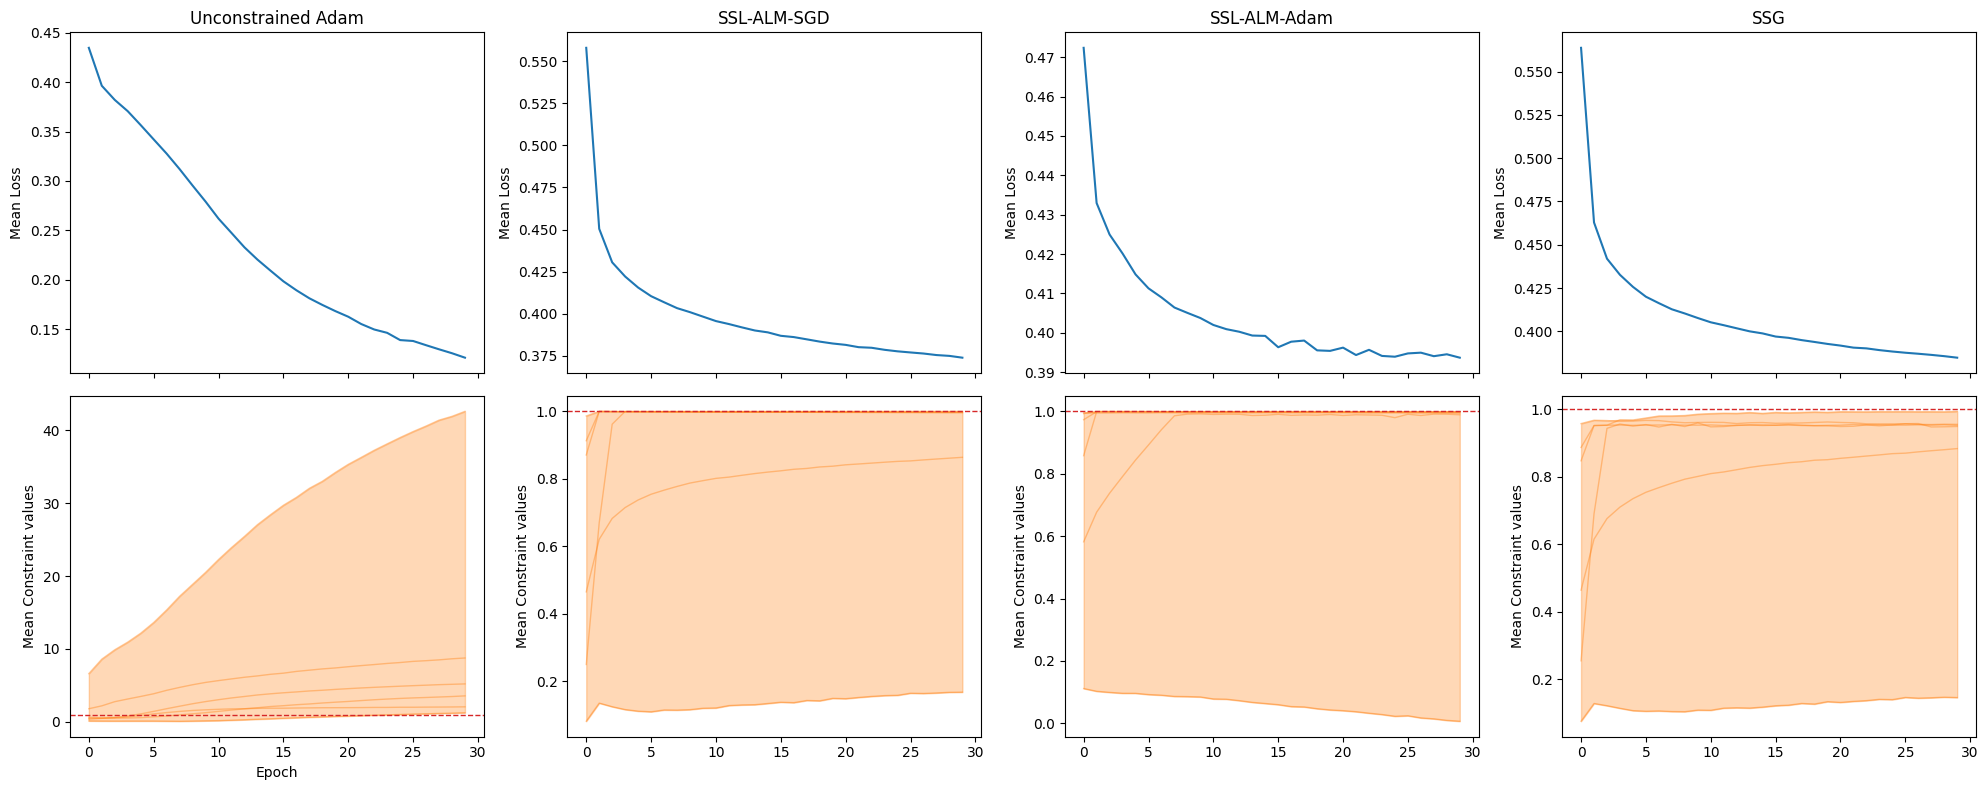

In [ ]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
losses_std = np.load(log_path)["losses_std"]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints_multi(losses, constraints, thresholds, losses_std_list=losses_std,  std_multiplier=1,
                                  titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam', 'SSG'], plot_individual_constraints=True)

#### 4. Cooper - Augmented Lagrangian

In [22]:
# set the seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network - same as the other algorithms
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# bounds for the constraints: norm of max each weight matrix should be <= 1
constraint_bounds = [1.]*m

# define epochs + loss function - same loss should be defined for all algorithms
criterion = torch.nn.BCEWithLogitsLoss()

In [23]:
import cooper

# select device
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = "cpu"

# define the problem
class ACS_Deterministic_Constr_Fair_ALM(cooper.ConstrainedMinimizationProblem):
    def __init__(self, formulation_type):
        super().__init__()


        # define the number of multipliers - same as the number of constraints
        if not formulation_type.expects_multiplier:
            self.multiplier = None
        else:
            self.multiplier = cooper.multipliers.DenseMultiplier(num_constraints=len(list(model.parameters())), device=DEVICE) 

        # add the penalty coefficient - augmented lagrangian
        if not formulation_type.expects_penalty_coefficient:
            self.penalty = None
        else:
            self.penalty = cooper.penalty_coefficients.DensePenaltyCoefficient(
                init=torch.tensor(1.0, device=DEVICE),
            )
        
        # inequality constraints on the norm of the matrix
        self.constraint = cooper.Constraint(
            constraint_type=cooper.ConstraintType.INEQUALITY,
            formulation_type=formulation_type,
            multiplier=self.multiplier,
            penalty_coefficient=self.penalty,
        )


    # function that computes the constraints and the loss function
    def compute_cmp_state(self, model, inputs, targets):

        # compute the yhat loss
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        loss = criterion( model(inputs) , targets )

        # calculate constraints
        norm_values_c = []
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # compute the violation of the constraint
            norm_viol = norm - constraint_bounds[i] 
            norm_values_c.append(norm_viol)
        
        # compute the constraint violation
        constraint_state = cooper.ConstraintState(violation=torch.stack(norm_values_c))
        observed_constraints = {self.constraint: constraint_state}

        return cooper.CMPState(loss=loss, observed_constraints=observed_constraints)


In [24]:
# create the problem
problem = ACS_Deterministic_Constr_Fair_ALM(cooper.formulations.AugmentedLagrangian)

# flag of dual variables
has_dual_variables = problem.multiplier is not None

# create the primal optimizer
primal_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# create the dual optimizer
if has_dual_variables:
    dual_optimizer = torch.optim.SGD(problem.dual_parameters(), lr=0.1, maximize=True)

    # combine the optimizers
    constrained_optimizer = cooper.optim.SimultaneousOptimizer(
        cmp=problem,
        primal_optimizers=primal_optimizer,
        dual_optimizers=dual_optimizer,
    )
else:
    # Formulations without dual variables, such as the Quadratic Penalty
    # formulation, do not require a dual optimizer
    constrained_optimizer = cooper.optim.UnconstrainedOptimizer(
        cmp=problem,
        primal_optimizers=primal_optimizer,
    )

# Increase the penalty coefficient by `increment` if the constraint is violate by more
# than `violation_tolerance`- keep this the same - since its not included in SSL-ALM implementation
penalty_scheduler = cooper.penalty_coefficients.AdditivePenaltyCoefficientUpdater(
    increment=0.0, 
    violation_tolerance=1e-3,
)

In [25]:
# alloc arrays for plotting
Cooper_c_log_plotting    = []
Cooper_loss_log_plotting = []

# training loop
for epoch in range(n_epochs):

    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []
    penalty_coefficient_values = []

    # alloc norm values array
    norm_values_c = []

    # go through all data
    for batch_input, batch_label in dataloader:

        # calculate constraints - just for logging
        c_log.append([])
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # compute the loss - just for logging purposes
        loss = criterion( model(batch_input) , batch_label )
        loss_log.append(loss.item())

        # compute the states
        compute_cmp_state_kwargs = {"model": model, "inputs": batch_input, "targets": batch_label}
        roll_out = constrained_optimizer.roll(compute_cmp_state_kwargs=compute_cmp_state_kwargs)

        # Update the penalty coefficient
        constraint_state = roll_out.cmp_state.observed_constraints[problem.constraint]
        penalty_scheduler.update_penalty_coefficient_(problem.constraint, constraint_state)

        # get the dual variables and the coefficients
        multiplier_value = problem.multiplier.weight.detach().numpy() if has_dual_variables else None
        penalty_coefficient_value = problem.constraint.penalty_coefficient().item()

        # save the duals and penalty coefficients
        duals_log.append(multiplier_value)
        penalty_coefficient_values.append(penalty_coefficient_value)

    # save the epoch values for plotting
    Cooper_loss_log_plotting.append(np.mean(loss_log))
    Cooper_c_log_plotting.append(np.mean(c_log, axis=0))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}, "
        f"penalty coefficients: {np.mean(penalty_coefficient_values, axis=0)}, "
    )
    

Epoch: 0, loss: 0.4694080853599093, constraints: [0.99977535 0.8927813  0.9987209  0.56353205 0.9767968  0.11757322], dual: [ 0.12802611 -0.00722992  0.04998935 -0.04362014  0.03313114 -0.08820604], penalty coefficients: 1.0, 
Epoch: 1, loss: 0.44417348637066434, constraints: [1.0000086  0.99931973 0.99949604 0.70522237 0.99947864 0.10355154], dual: [ 0.14721684  0.00708862  0.05724068 -0.02946182  0.04814353 -0.08960644], penalty coefficients: 1.0, 
Epoch: 2, loss: 0.4364263997050051, constraints: [0.99985147 0.9990649  0.9996338  0.86919904 0.99936914 0.09342793], dual: [ 0.14683396  0.00689173  0.05955346 -0.01307087  0.05227868 -0.09061798], penalty coefficients: 1.0, 
Epoch: 3, loss: 0.43257614246454973, constraints: [1.0000596  0.9993597  1.0000476  0.9840256  0.9996412  0.08345351], dual: [ 0.14557114  0.00726979  0.06181119 -0.00132039  0.05504715 -0.09161504], penalty coefficients: 1.0, 
Epoch: 4, loss: 0.4285752162001575, constraints: [1.0001726  0.9992785  0.9999631  0.99060

In [26]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])

# append
losses += [np.array(SSG_loss_log_plotting)]
constraints += [np.array(SSG_c_log_plotting).T]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints)

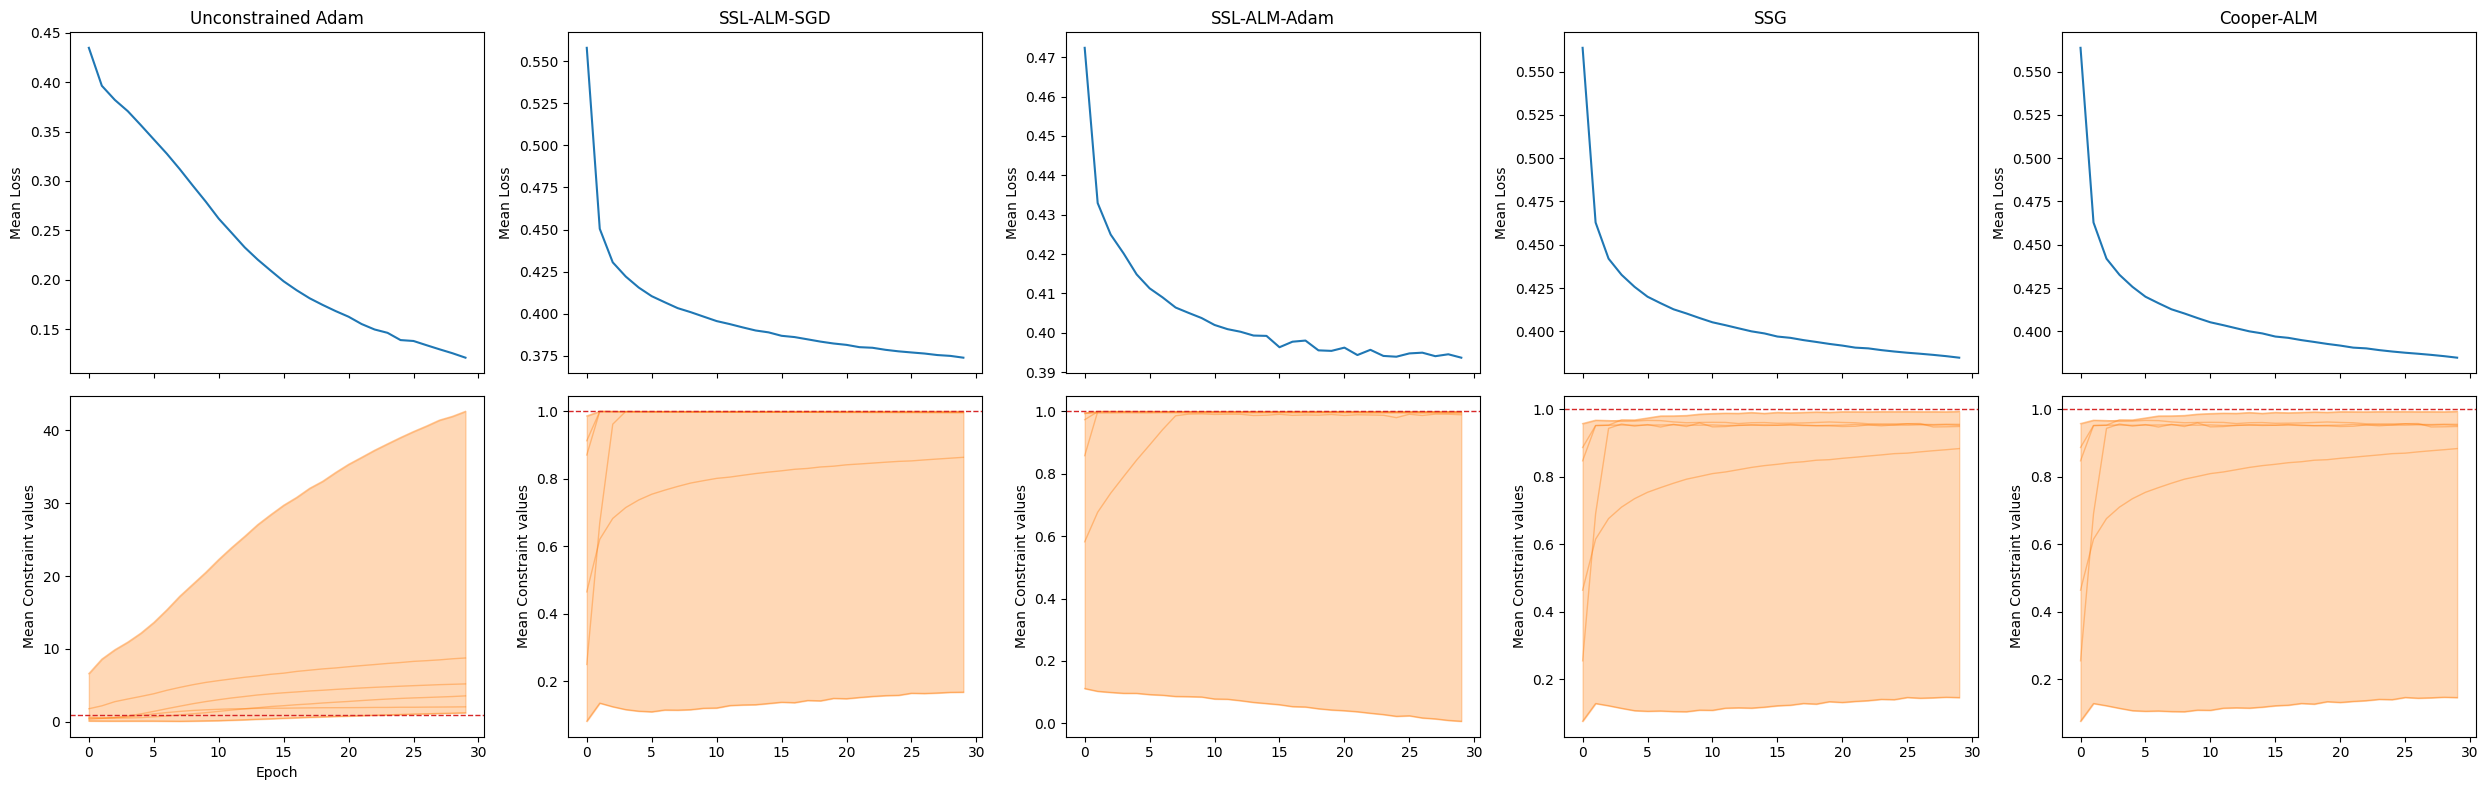

In [27]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints(losses, constraints, thresholds, titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam', 'SSG', 'Cooper-ALM'], plot_individual_constraints=True)

#### 5. CHOP

The library is based on the [Stochastic Franke-Wolfe (SFW)](https://arxiv.org/pdf/2010.07243), which constraints the parameters on a convex set. Thus, the model weights are to be in a closed ball, simplex and such. This can only be used for the determinitic case of benchmarking but cannot be extended to the stochastic constrained case. 

NOTE: The repo has an error in it. <code>chop/constraints.py</code>, line 292: 

<code>update_direction = iterate.clone().detach()</code> change to 

<code>update_direction = -iterate.clone().detach()</code>

In [36]:
import chop

# set the seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network - same as the other algorithms
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# bounds for the constraints: norm of max each weight matrix should be <= 1
constraint_bounds = [1.]

# define epochs + loss function - same loss should be defined for all algorithms
criterion = torch.nn.BCEWithLogitsLoss()

In [37]:
# create an optimizer with a ball constraints
optimizer = chop.stochastic.FrankWolfe(model.parameters(), chop.constraints.L2Ball(alpha=constraint_bounds[0]),
                                       lr=0.001, momentum=0.9,
                                       normalization='gradient')

bias_params = [param for name, param in model.named_parameters() if 'bias' in name]
bias_opt = chop.stochastic.PGD(bias_params, chop.constraints.L2Ball(alpha=constraint_bounds[0]), lr=0.001)

# project the model weights into the feasible region (an assumption of the franke-wolfe)
for i, param in enumerate(model.parameters()):
    param_proj = chop.constraints.L2Ball(alpha=constraint_bounds[0]).prox(param)

    # Update the parameter in-place
    with torch.no_grad():
        param.copy_(param_proj)

In [38]:
# alloc arrays for plotting
CHOP_c_log_plotting    = []
CHOP_loss_log_plotting = []

model.train()   

# training loop
for epoch in range(n_epochs):

    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []

    # alloc norm values array
    norm_values_c = []

    # go through all data
    for batch_input, batch_label in dataloader:

        # calculate constraints - just for logging
        c_log.append([])
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # compute the loss - just for logging purposes
        optimizer.zero_grad()
        bias_opt.zero_grad()
        loss = criterion(model(batch_input), batch_label)
        loss.backward()
        optimizer.step()
        bias_opt.step()

        # save the loss for later
        loss_log.append(loss.item())

    # save the epoch values for plotting
    CHOP_loss_log_plotting.append(np.mean(loss_log))
    CHOP_c_log_plotting.append(np.mean(c_log, axis=0))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )
    

Epoch: 0, loss: 0.6901379895220596, constraints: [0.71410966 0.15037718 0.9213575  0.38696805 0.5187366  0.05996813], 
Epoch: 1, loss: 0.6815355538650443, constraints: [0.6719315  0.14869304 0.89898914 0.3906492  0.4921078  0.1221429 ], 
Epoch: 2, loss: 0.6796294381290002, constraints: [0.6299808  0.14887948 0.87930346 0.38907287 0.48109508 0.1448769 ], 
Epoch: 3, loss: 0.6777218506644049, constraints: [0.58743733 0.15071158 0.8603447  0.386782   0.47844154 0.14673577], 
Epoch: 4, loss: 0.6753192744645543, constraints: [0.5429646  0.15495576 0.8416517  0.3857915  0.48474053 0.14734434], 
Epoch: 5, loss: 0.6719240562238148, constraints: [0.49571553 0.16358942 0.8225961  0.38524923 0.5029483  0.13464458], 
Epoch: 6, loss: 0.6671010472745581, constraints: [0.44832343 0.17927991 0.80298394 0.38860273 0.53512126 0.12838209], 
Epoch: 7, loss: 0.6598202929391398, constraints: [0.40977186 0.20765392 0.78299564 0.3940621  0.58376724 0.11594684], 
Epoch: 8, loss: 0.6485556775713711, constraints:

In [50]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])

# append
losses += [np.array(CHOP_loss_log_plotting)]
constraints += [np.array(CHOP_c_log_plotting).T]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints)

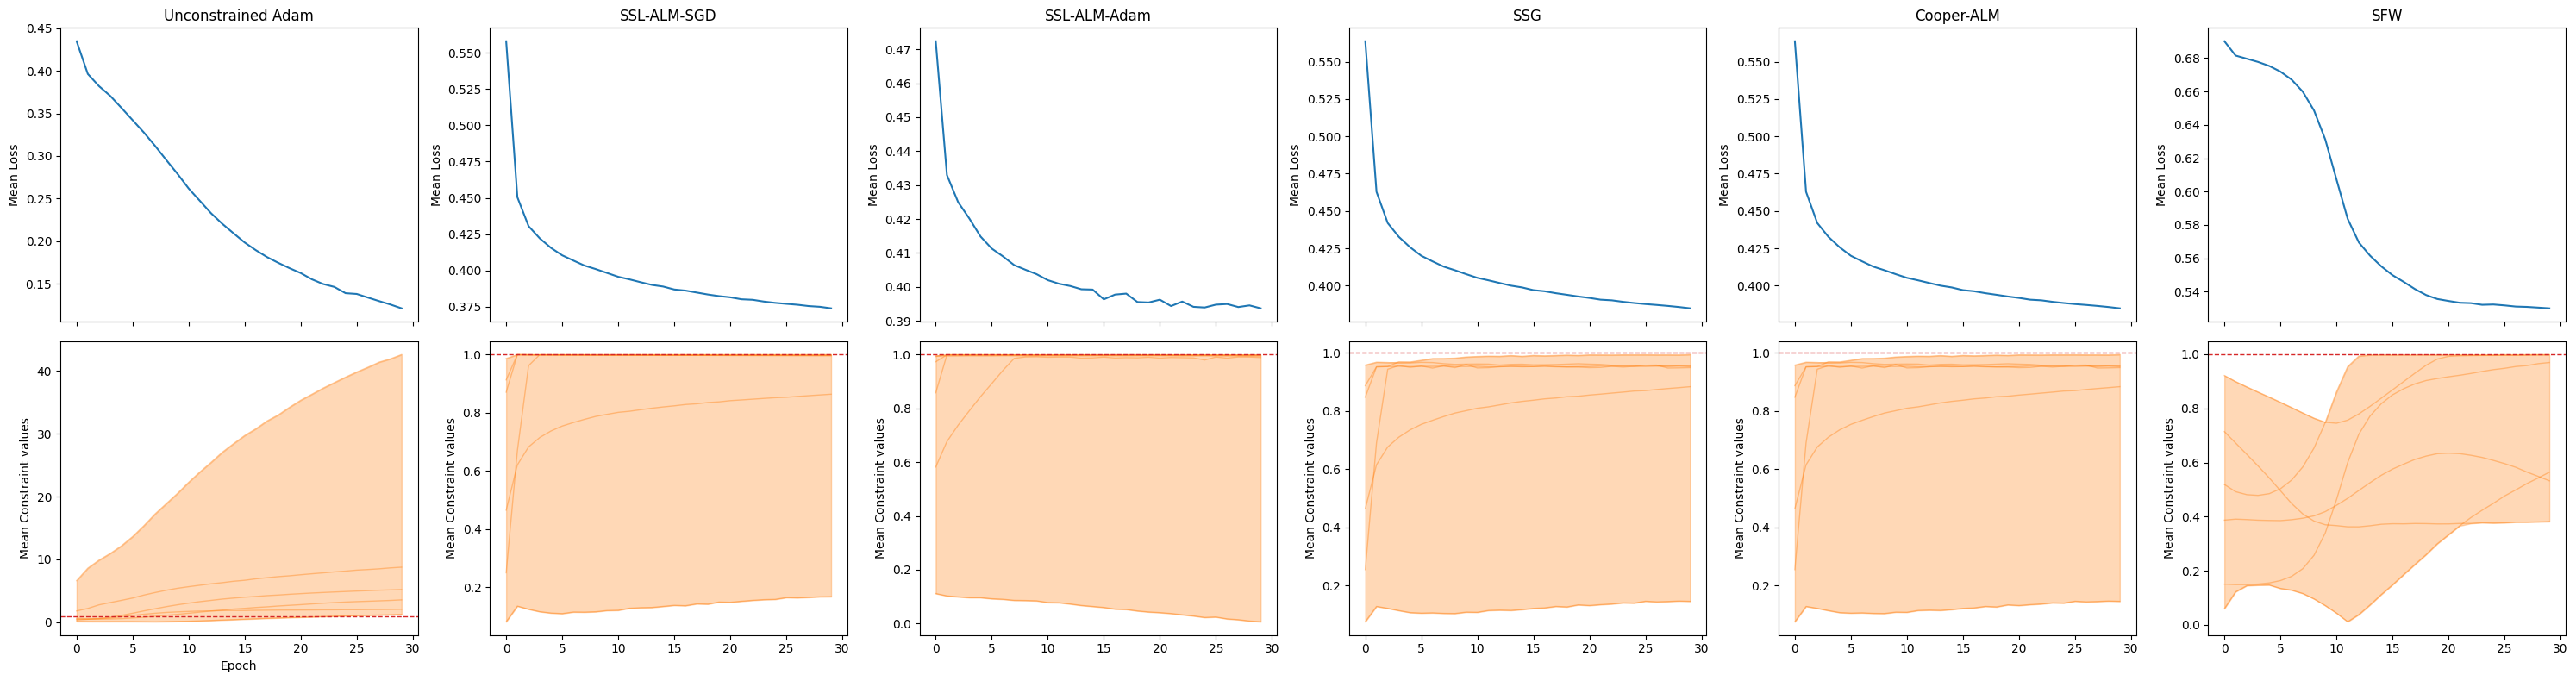

In [60]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints(losses, constraints, thresholds, titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam', 'SSG', 'Cooper-ALM', 'SFW'], plot_individual_constraints=True)

#### Results

To better compare the results, we plot all losses in a single Figure.

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def plot_losses_and_constraints_single(
    losses_list,
    constraints_list,
    constraint_thresholds,
    titles=None,
    plot_individual_constraints=True,
    eval_points=2,
):
    """
    Plot all losses together (top row) and all constraints together (bottom row).
    Each algorithm's loss curve uses a unique marker, shown directly on the line.

    Parameters
    ----------
    losses_list : list of np.ndarray
        Each element is a 1D array of loss values for one algorithm.
    constraints_list : list of list of np.ndarray
        Each element is a list of 1D arrays (constraint values for that algorithm).
    constraint_thresholds : np.ndarray or list
        One or more threshold values to plot as dashed lines (same for all algos).
    titles : list of str, optional
        Algorithm names (for legend).
    plot_individual_constraints : bool, optional (default=True)
        If True, plots all individual constraint curves.
    eval_points : int, list, or None
        - If int: place markers every `eval_points` steps.
        - If list/array: explicit indices of evaluation points.
        - If None: no markers.
    """
    num_algos = len(losses_list)
    if titles is None:
        titles = [f"Algorithm {i+1}" for i in range(num_algos)]
    constraint_thresholds = np.atleast_1d(constraint_thresholds)

    # --- Predefine marker styles ---
    marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', 'P', 'X', '*']
    marker_styles = (marker_styles * ((num_algos // len(marker_styles)) + 1))[:num_algos]

    # --- Create figure: 2 rows, 1 column ---
    fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=False)
    ax_loss, ax_constr = axes

    # === FIRST ROW: all losses in one plot ===
    for j, loss in enumerate(losses_list):
        x = np.arange(len(loss))

        # --- Determine marker positions ---
        if eval_points is not None:
            if isinstance(eval_points, int):
                eval_idx = np.arange(0, len(loss), eval_points)
            else:
                eval_idx = np.asarray(eval_points)
                eval_idx = eval_idx[eval_idx < len(loss)]
            # To show markers only at those points, mask the rest
            marker_every = eval_points if isinstance(eval_points, int) else None
        else:
            eval_idx = None
            marker_every = None

        # --- Plot line with markers integrated into it ---
        ax_loss.plot(
            x,
            loss,
            label=titles[j],
            color=f"C{j}",
            linewidth=1.8,
            marker=marker_styles[j] if eval_points is not None else None,
            markevery=eval_idx if eval_points is not None else None,
            markersize=6,
            markerfacecolor=f"C{j}",
            markeredgewidth=0.0
        )

    ax_loss.set_ylabel('Mean Loss')
    ax_loss.set_title('Loss Comparison')
    ax_loss.legend(loc='upper right', fontsize=8)
    ax_loss.grid(True, linestyle='--', alpha=0.4)

    # === SECOND ROW: all constraints together ===
    for j, constraints in enumerate(constraints_list):
        constraints = np.log(np.array(constraints))  # shape (num_constraints, timesteps)

        print(constraints)
        print(constraints.shape)
        x = np.arange(constraints.shape[1])
        c_min = np.min(constraints, axis=0)
        c_max = np.max(constraints, axis=0)

        if plot_individual_constraints:
            for c in constraints:
                ax_constr.plot(x, c, color=f"C{j}", alpha=0.3, linewidth=1)

        ax_constr.fill_between(x, c_min, c_max, color=f"C{j}", alpha=0.25, label=f"{titles[j]} (log range)")

    for th in constraint_thresholds:
        ax_constr.axhline(np.log(th), color='tab:red', linestyle='--', linewidth=1, label='Log Threshold')

    ax_constr.set_ylabel('Log Constraint values')
    ax_constr.set_xlabel('Epoch')
    ax_constr.set_title('Constraint Comparison')
    ax_constr.legend(loc='upper right', fontsize=8)
    ax_constr.grid(True, linestyle='--', alpha=0.4)

    fig.subplots_adjust(hspace=0.3, top=0.95, bottom=0.08)
    plt.tight_layout()
    plt.show()


In [74]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints_single(losses, constraints, thresholds, titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam', 'SSG', 'Cooper-ALM', 'SFW'], plot_individual_constraints=True)

NameError: name 'plot_losses_and_constraints_single' is not defined

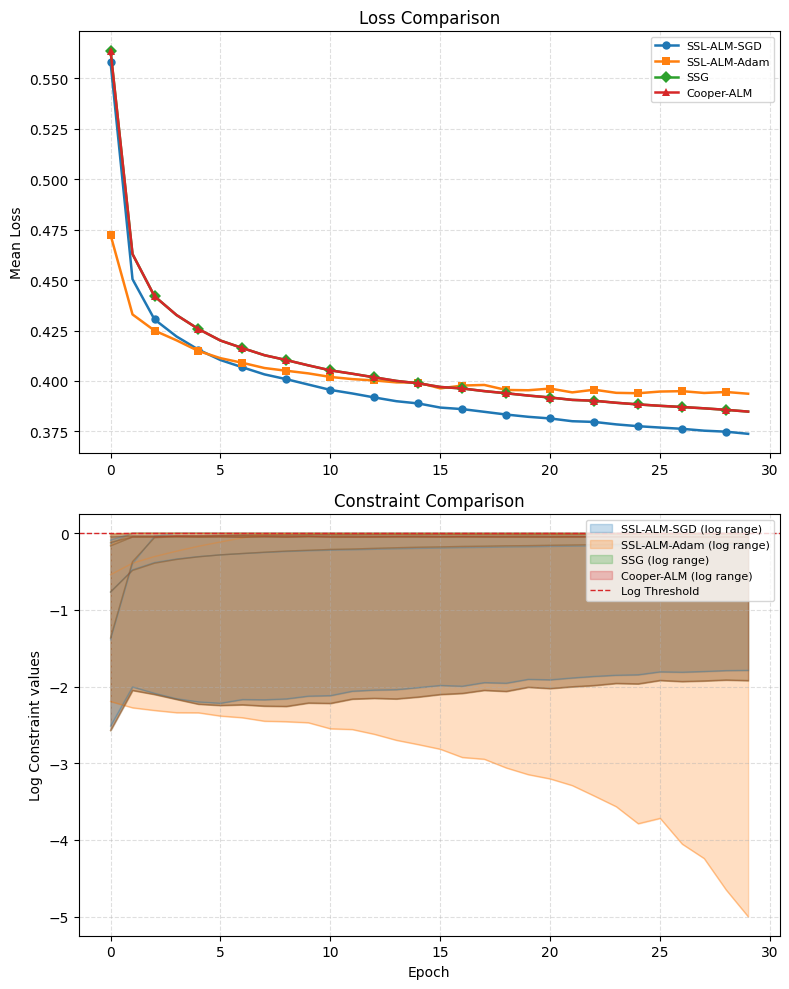

In [11]:
# plot everything into a single graph - focus only on SSL-ALM, SSG, and Cooper-ALM
losses = np.load(log_path)["losses"][1:-1]
constraints = np.load(log_path)["constraints"][1:-1]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints_single(losses, constraints, thresholds, titles=['SSL-ALM-SGD', 'SSL-ALM-Adam', 'SSG', 'Cooper-ALM'], plot_individual_constraints=True)

# Stochastic constraints: 

TODO: define the problem mathematically
cooper with importance sampling and without

#### 1. Unconstrained Optimization

In [77]:
# define the torch seed here
seed_n = 1
n_epochs = 50

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# log path file
log_path = "./data/logs/log_benchmark_stochastic.npz"

In [78]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

# get the dataset
dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

# create a balanced sampling - needed for an unbiased gradient
sampler = BalancedBatchSampler(
    subgroup_onehot=sens_train,
    batch_size=128,
    drop_last=True
)
# create a dataloader from the sampler
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

# define the criterion
criterion = torch.nn.BCEWithLogitsLoss()
statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2  # define the bound on the criterion

In [79]:
import torch
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# create the SSLALM optimizer
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [80]:
# alloc arrays for plotting
Adam_S_loss_log_plotting = [] # mean
Adam_S_c_log_plotting    = [] # mean
Adam_S_loss_std_log_plotting = [] # std
Adam_S_c_std_log_plotting = [] # std

# training loop
for epoch in range(n_epochs):
    
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:
        
        # calculate constraints and constraint grads
        out = model(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        
        # calculate the fair constraint violation
        fair_constraint = fair_loss

        # save the fair loss violation for logging
        c_log.append([fair_loss.detach().item()])
        
        # calculate primal loss and grad
        loss = criterion(out, batch_label) 
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step()
        optimizer.zero_grad()

    Adam_S_c_log_plotting.append(np.mean(c_log, axis=0))
    Adam_S_loss_log_plotting.append(np.mean(loss_log))
    Adam_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    Adam_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

Epoch: 0, loss: 0.4592224359512329, constraints: [0.1826899], 
Epoch: 1, loss: 0.3946727514266968, constraints: [0.23917505], 
Epoch: 2, loss: 0.38275301456451416, constraints: [0.25753427], 
Epoch: 3, loss: 0.3711405396461487, constraints: [0.26047066], 
Epoch: 4, loss: 0.3627611994743347, constraints: [0.26348149], 
Epoch: 5, loss: 0.35257962346076965, constraints: [0.26123586], 
Epoch: 6, loss: 0.34168747067451477, constraints: [0.26991869], 
Epoch: 7, loss: 0.33115535974502563, constraints: [0.27108348], 
Epoch: 8, loss: 0.31729456782341003, constraints: [0.27725613], 
Epoch: 9, loss: 0.3045879304409027, constraints: [0.27825432], 
Epoch: 10, loss: 0.2907879650592804, constraints: [0.28925386], 
Epoch: 11, loss: 0.2775413990020752, constraints: [0.29255645], 
Epoch: 12, loss: 0.2654717266559601, constraints: [0.29590179], 
Epoch: 13, loss: 0.25202834606170654, constraints: [0.3035675], 
Epoch: 14, loss: 0.2405117005109787, constraints: [0.30330954], 
Epoch: 15, loss: 0.230178177356

In [81]:
import numpy as np
import matplotlib.pyplot as plt

def plot_losses_and_constraints_single_stochastic(
    losses_list,
    losses_std_list,
    constraints_list,
    constraints_std_list,
    constraint_thresholds,
    titles=None,
    eval_points=2,
    std_multiplier=2,
    log_constraints=False
):
    # --- Color palette: Tableau 10 ---
    colors = [
        "#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F",
        "#EDC948", "#B07AA1", "#FF9DA7", "#9C755F", "#BAB0AB"
    ]

    # --- Marker styles (reused from inspired function) ---
    marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', 'P', 'X', '*']
    marker_styles = (marker_styles * ((len(losses_list) // len(marker_styles)) + 1))[:len(losses_list)]

    num_algos = len(losses_list)
    if titles is None:
        titles = [f"Algorithm {i+1}" for i in range(num_algos)]
    constraint_thresholds = np.atleast_1d(constraint_thresholds)

    fig, axes = plt.subplots(2, 1, figsize=(9, 11))
    ax_loss, ax_constr = axes

    # --- LOSS PLOT ---
    for j, (loss, loss_std) in enumerate(zip(losses_list, losses_std_list)):
        x = np.arange(len(loss))
        color = colors[j % len(colors)]
        upper = loss + std_multiplier * loss_std
        lower = loss - std_multiplier * loss_std

        # Mean curve
        ax_loss.plot(x, loss, lw=2.2, color=color, label=titles[j])
        # Std shading
        ax_loss.fill_between(x, lower, upper, color=color, alpha=0.15)

        # Eval points
        if eval_points is not None:
            if isinstance(eval_points, int):
                idx = np.arange(0, len(loss), eval_points)
            else:
                idx = np.array(eval_points)
                idx = idx[idx < len(loss)]
            ax_loss.plot(
                x[idx],
                loss[idx],
                marker_styles[j],
                color=color,
                markersize=6,
                alpha=0.8
            )

    ax_loss.set_ylabel("Mean Loss")
    ax_loss.set_title("Loss Comparison")
    ax_loss.grid(True, linestyle="--", alpha=0.35)
    ax_loss.legend(fontsize=9)

    # --- CONSTRAINT PLOT ---
    for j, (constraints, constraints_std) in enumerate(zip(constraints_list, constraints_std_list)):
        color = colors[j % len(colors)]
        constraints = np.array(constraints)
        constraints_std = np.array(constraints_std)
        x = np.arange(constraints.shape[1])

        c_min = np.min(constraints - std_multiplier * constraints_std, axis=0)
        c_max = np.max(constraints + std_multiplier * constraints_std, axis=0)

        # Fill min-max range
        ax_constr.fill_between(x, c_min, c_max, color=color, alpha=0.15, label=titles[j])

        # Plot mean curves with markers
        for c_mean in constraints:
            ax_constr.plot(x, c_mean, lw=1.8, color=color, alpha=0.7)
            if eval_points is not None:
                if isinstance(eval_points, int):
                    idx = np.arange(0, len(c_mean), eval_points)
                else:
                    idx = np.array(eval_points)
                    idx = idx[idx < len(c_mean)]
                ax_constr.plot(
                    x[idx],
                    c_mean[idx],
                    marker_styles[j],
                    color=color,
                    markersize=5,
                    alpha=0.8
                )

    # Threshold lines
    for th in constraint_thresholds:
        y = np.log(th) if log_constraints else th
        ax_constr.axhline(y, color="red", linestyle="--", lw=1.4, label="Threshold")

    ax_constr.set_ylabel("Log Constraint" if log_constraints else "Constraint")
    ax_constr.set_xlabel("Epoch")
    ax_constr.set_title("Constraint Comparison")
    ax_constr.grid(True, linestyle="--", alpha=0.35)
    ax_constr.legend(fontsize=9)

    plt.tight_layout()
    plt.show()


In [82]:
# save the computed data
np.savez(log_path, losses=[np.array(Adam_S_loss_log_plotting)], constraints=[np.array(Adam_S_c_log_plotting).T], 
                    losses_std=[np.array(Adam_S_loss_std_log_plotting)], constraints_std=[np.array(Adam_S_c_std_log_plotting).T])

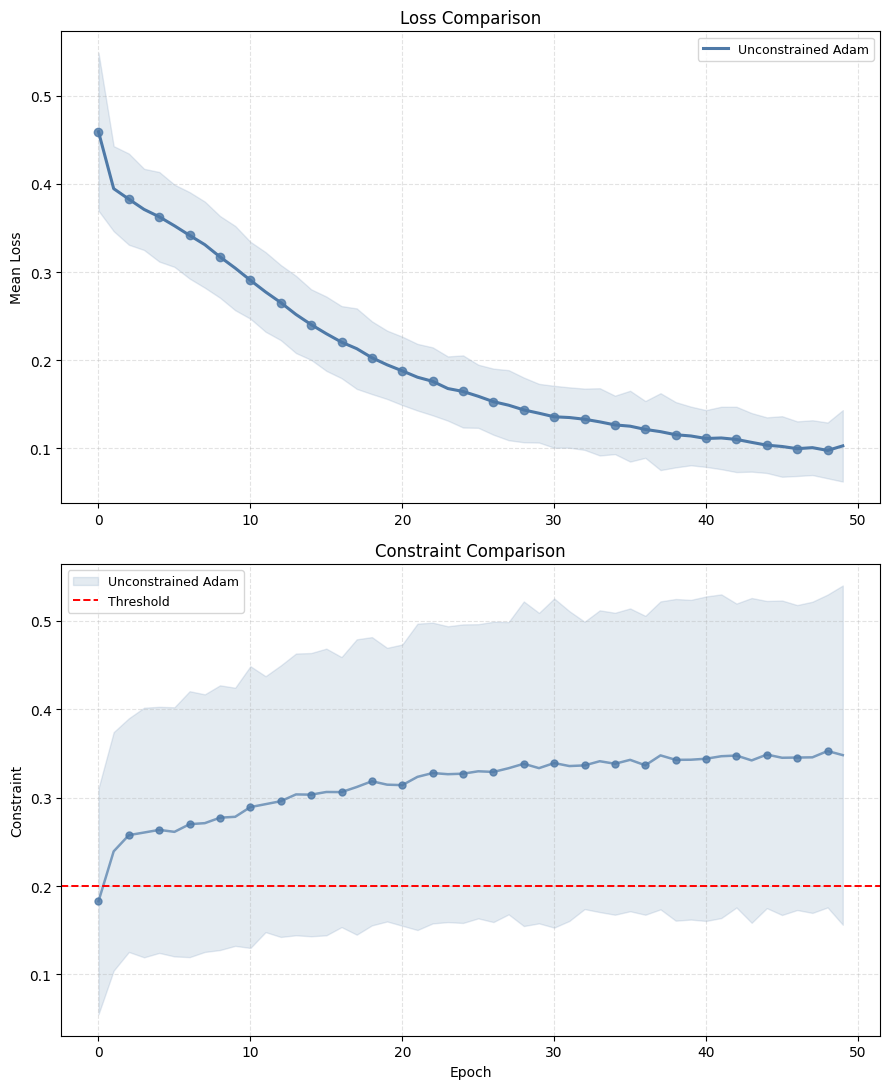

In [83]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
thresholds = [ fair_crit_bound ]

plot_losses_and_constraints_single_stochastic(losses, losses_std, constraints, constraints_std, thresholds, 
                                              titles=['Unconstrained Adam'], 
                                              log_constraints=False, std_multiplier=1)

#### 2.1 SSL-ALM SGD

In [84]:
from humancompatible.train.algorithms import SSLALM
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

optimizer = SSLALM(
    params=model_con.parameters(),
    m=1, # number of constraints - one in our case
    lr=0.1, # primal variable lr
    dual_lr=0.05, # lr of a dual ALM variable
    dual_bound=5,
    rho=1, # rho penalty in ALM parameter
    mu=2, # smoothing parameter
)

# add slack variables - to create the equality from the inequalities
slack_vars = torch.zeros(1, requires_grad=True)
optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

In [85]:
# alloc arrays for plotting
SSLALM_SGD_S_loss_log_plotting = [] # mean
SSLALM_SGD_S_c_log_plotting    = [] # mean
SSLALM_SGD_S_loss_std_log_plotting = [] # std
SSLALM_SGD_S_c_std_log_plotting = [] # std

# training loop
for epoch in range(n_epochs):
    
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:
        
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        
        # calculate the fair constraint violation
        fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
        fair_constraint.backward(retain_graph=True)

        # perform the dual step variable + save the dual grad for later        
        optimizer.dual_step(0, c_val=fair_constraint)
        optimizer.zero_grad()

        # save the fair loss violation for logging
        c_log.append([fair_loss.detach().item()])
        duals_log.append(optimizer._dual_vars.detach())
        
        # calculate primal loss and grad
        loss = criterion(out, batch_label) + 0 * slack_vars[0] # need to add 0*slack variables for autograd to work
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step()
        optimizer.zero_grad()

        # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()
        
    optimizer.dual_lr *= 0.95
    SSLALM_SGD_S_c_log_plotting.append(np.mean(c_log, axis=0))
    SSLALM_SGD_S_loss_log_plotting.append(np.mean(loss_log))
    SSLALM_SGD_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    SSLALM_SGD_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.5476123690605164, constraints: [0.07866101], dual: [0.00845639]
Epoch: 1, loss: 0.4131006598472595, constraints: [0.18581737], dual: [0.03697782]
Epoch: 2, loss: 0.394643098115921, constraints: [0.19702015], dual: [0.07289013]
Epoch: 3, loss: 0.38410887122154236, constraints: [0.19430995], dual: [0.09832019]
Epoch: 4, loss: 0.37728992104530334, constraints: [0.19308986], dual: [0.07235397]
Epoch: 5, loss: 0.3715454339981079, constraints: [0.19137347], dual: [0.075288]
Epoch: 6, loss: 0.36716997623443604, constraints: [0.19032816], dual: [0.04052112]
Epoch: 7, loss: 0.36228394508361816, constraints: [0.19502162], dual: [0.05839768]
Epoch: 8, loss: 0.35755595564842224, constraints: [0.19642572], dual: [0.06575448]
Epoch: 9, loss: 0.3538602590560913, constraints: [0.19339319], dual: [0.04550575]
Epoch: 10, loss: 0.3490326702594757, constraints: [0.1991729], dual: [0.08412839]
Epoch: 11, loss: 0.3447719216346741, constraints: [0.19906746], dual: [0.10788523]
Epoch: 12, lo

In [86]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"]) 
constraints_std = list(np.load(log_path)["constraints_std"]) 

# append
losses += [np.array(SSLALM_SGD_S_loss_log_plotting)]
constraints += [np.array(SSLALM_SGD_S_c_log_plotting).T]
losses_std += [np.array(SSLALM_SGD_S_loss_std_log_plotting)]
constraints_std += [np.array(SSLALM_SGD_S_c_std_log_plotting).T]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std, constraints_std=constraints_std)

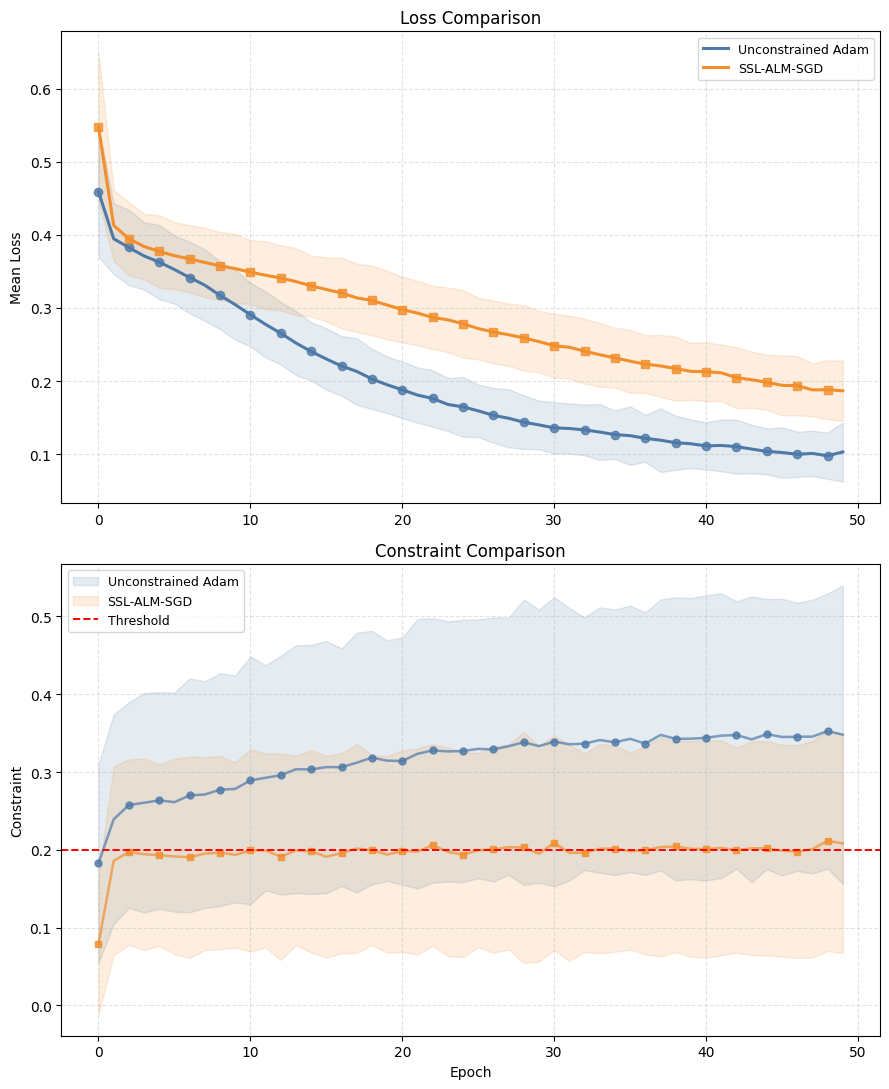

In [87]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
thresholds = [ fair_crit_bound ]

plot_losses_and_constraints_single_stochastic(losses, losses_std, constraints, constraints_std, thresholds, titles=['Unconstrained Adam', 'SSL-ALM-SGD'], log_constraints=False, std_multiplier=1)

#### 2.2 SSL-ALM Adam

In [88]:
from torch.nn import Sequential
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.humancompatible.train.optim.ssl_alm_adam import SSLALM_Adam

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

optimizer = SSLALM_Adam(
    params=model_con.parameters(),
    m=1, # number of constraints - one in our case
    lr=0.01, # primal variable lr
    dual_lr=0.05, # lr of a dual ALM variable
    dual_bound=5,
    rho=1, # rho penalty in ALM parameter
    mu=2, # smoothing parameter
)

# add slack variables - to create the equality from the inequalities
slack_vars = torch.zeros(1, requires_grad=True)
optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

In [89]:
# alloc arrays for plotting
SSLALM_S_loss_log_plotting = [] # mean
SSLALM_S_c_log_plotting    = [] # mean
SSLALM_S_loss_std_log_plotting = [] # std
SSLALM_S_c_std_log_plotting = [] # std

# training loop
for epoch in range(n_epochs):
    
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:
        
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        
        # calculate the fair constraint violation
        fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
        fair_constraint.backward(retain_graph=True)

        # perform the dual step variable + save the dual grad for later        
        optimizer.dual_step(0, c_val=fair_constraint)
        optimizer.zero_grad()

        # save the fair loss violation for logging
        c_log.append([fair_loss.detach().item()])
        duals_log.append(optimizer._dual_vars.detach())
        
        # calculate primal loss and grad
        loss = criterion(out, batch_label) + 0* slack_vars[0]
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step()
        optimizer.zero_grad()

        # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()
        
    optimizer.dual_lr *= 0.95
    SSLALM_S_c_log_plotting.append(np.mean(c_log, axis=0))
    SSLALM_S_loss_log_plotting.append(np.mean(loss_log))
    SSLALM_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    SSLALM_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.4735445976257324, constraints: [0.14126119], dual: [0.00236604]
Epoch: 1, loss: 0.4003300070762634, constraints: [0.19756161], dual: [0.03587616]
Epoch: 2, loss: 0.38659578561782837, constraints: [0.20250662], dual: [0.06765646]
Epoch: 3, loss: 0.376892626285553, constraints: [0.20180443], dual: [0.09345168]
Epoch: 4, loss: 0.36981266736984253, constraints: [0.19787789], dual: [0.0698868]
Epoch: 5, loss: 0.3627416491508484, constraints: [0.19944552], dual: [0.07329166]
Epoch: 6, loss: 0.35689303278923035, constraints: [0.19491077], dual: [0.02459923]
Epoch: 7, loss: 0.3503275215625763, constraints: [0.20148703], dual: [0.04691381]
Epoch: 8, loss: 0.34307992458343506, constraints: [0.20305414], dual: [0.07508791]
Epoch: 9, loss: 0.33702337741851807, constraints: [0.19652639], dual: [0.04470544]
Epoch: 10, loss: 0.3291666507720947, constraints: [0.20629361], dual: [0.09744155]
Epoch: 11, loss: 0.32286983728408813, constraints: [0.2004008], dual: [0.10061289]
Epoch: 12, 

In [90]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"]) 
constraints_std = list(np.load(log_path)["constraints_std"]) 

# append
losses += [np.array(SSLALM_S_loss_log_plotting)]
constraints += [np.array(SSLALM_S_c_log_plotting).T]
losses_std += [np.array(SSLALM_S_loss_std_log_plotting)]
constraints_std += [np.array(SSLALM_S_c_std_log_plotting).T]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std, constraints_std=constraints_std)

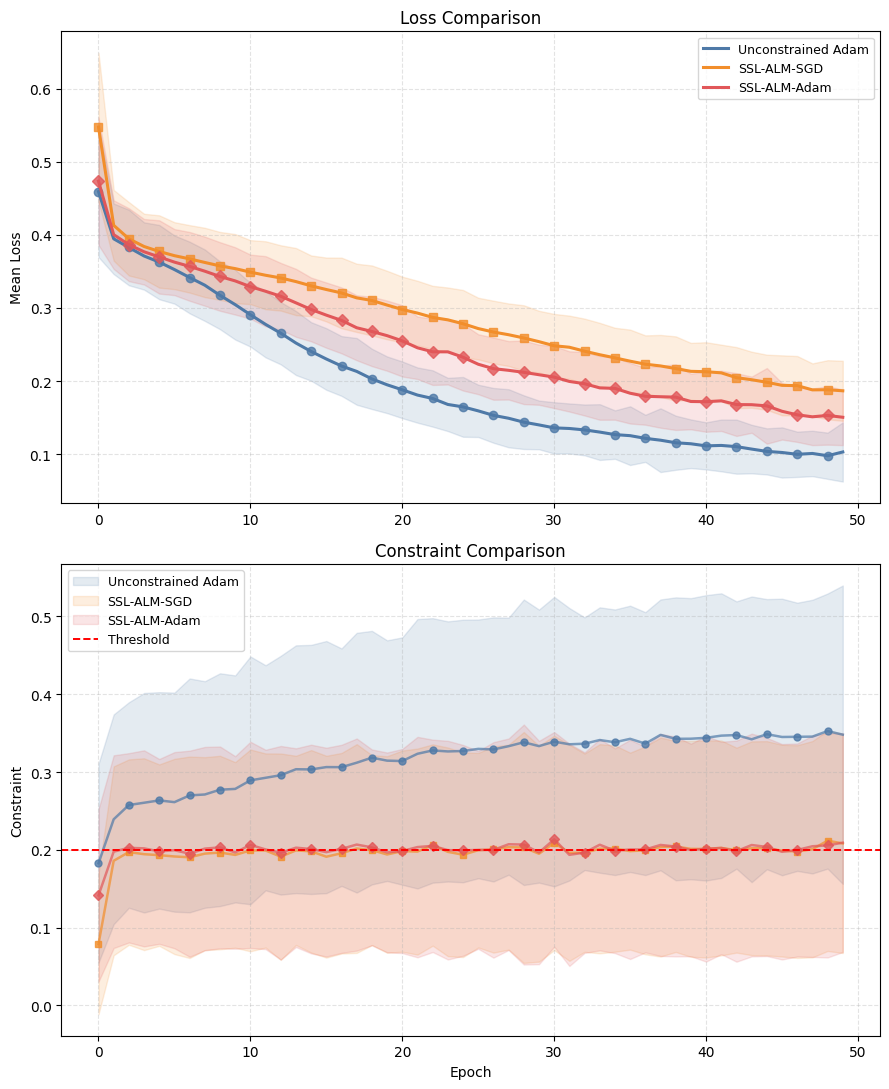

In [91]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
thresholds = [ fair_crit_bound ]

plot_losses_and_constraints_single_stochastic(losses, losses_std, constraints, constraints_std, thresholds, 
                                              titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam'], 
                                              log_constraints=False, std_multiplier=1)

#### 3. Switching-Subgradient

In [92]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

# get the dataset
dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

# create a balanced sampling - needed for an unbiased gradient
sampler = BalancedBatchSampler(
    subgroup_onehot=sens_train,
    batch_size=128,
    drop_last=True
)

# create a dataloader from the sampler
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

# define the criterion
criterion = torch.nn.BCEWithLogitsLoss()
statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [93]:
from humancompatible.train.algorithms import SSG
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# same network size for all algorithms
hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

optimizer = SSG(
    params=model_con.parameters(),
    m=1,
    lr=0.1,
    dual_lr=0.05
)

In [94]:
# alloc arrays for plotting
SSG_S_loss_log_plotting = [] # mean
SSG_S_c_log_plotting    = [] # mean
SSG_S_loss_std_log_plotting = [] # std
SSG_S_c_std_log_plotting = [] # std

# training loop
for epoch in range(n_epochs):

    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:

        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        fair_constraint = torch.max(fair_loss - fair_crit_bound, torch.zeros(1))
        fair_constraint.backward(retain_graph=True)
        
        # compute the grad of the constraints
        optimizer.dual_step(0)
        optimizer.zero_grad()

        # save the constraint value
        c_log.append([fair_loss.detach().item()])
        
        # calculate loss and grad
        loss = criterion(out, batch_label)
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step(fair_constraint)
        optimizer.zero_grad()
        
        
    SSG_S_c_log_plotting.append(np.mean(c_log, axis=0))
    SSG_S_loss_log_plotting.append(np.mean(loss_log))
    SSG_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    SSG_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

Epoch: 0, loss: 0.522874653339386, constraints: [0.08450851], 
Epoch: 1, loss: 0.42589524388313293, constraints: [0.12982562], 
Epoch: 2, loss: 0.40672022104263306, constraints: [0.14047133], 
Epoch: 3, loss: 0.3998394012451172, constraints: [0.12920718], 
Epoch: 4, loss: 0.39344871044158936, constraints: [0.1378811], 
Epoch: 5, loss: 0.388198584318161, constraints: [0.12967816], 
Epoch: 6, loss: 0.3840477466583252, constraints: [0.13636403], 
Epoch: 7, loss: 0.3800334930419922, constraints: [0.1344014], 
Epoch: 8, loss: 0.3772767186164856, constraints: [0.13726422], 
Epoch: 9, loss: 0.3723162114620209, constraints: [0.13584391], 
Epoch: 10, loss: 0.36924779415130615, constraints: [0.14337963], 
Epoch: 11, loss: 0.3664214015007019, constraints: [0.13781949], 
Epoch: 12, loss: 0.3654307425022125, constraints: [0.13988721], 
Epoch: 13, loss: 0.3608675003051758, constraints: [0.14370849], 
Epoch: 14, loss: 0.3568142056465149, constraints: [0.1382025], 
Epoch: 15, loss: 0.3536081612110138,

In [95]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"]) 
constraints_std = list(np.load(log_path)["constraints_std"]) 

# append
losses += [np.array(SSG_S_loss_log_plotting)]
constraints += [np.array(SSG_S_c_log_plotting).T]
losses_std += [np.array(SSG_S_loss_std_log_plotting)]
constraints_std += [np.array(SSG_S_c_std_log_plotting).T]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std, constraints_std=constraints_std)

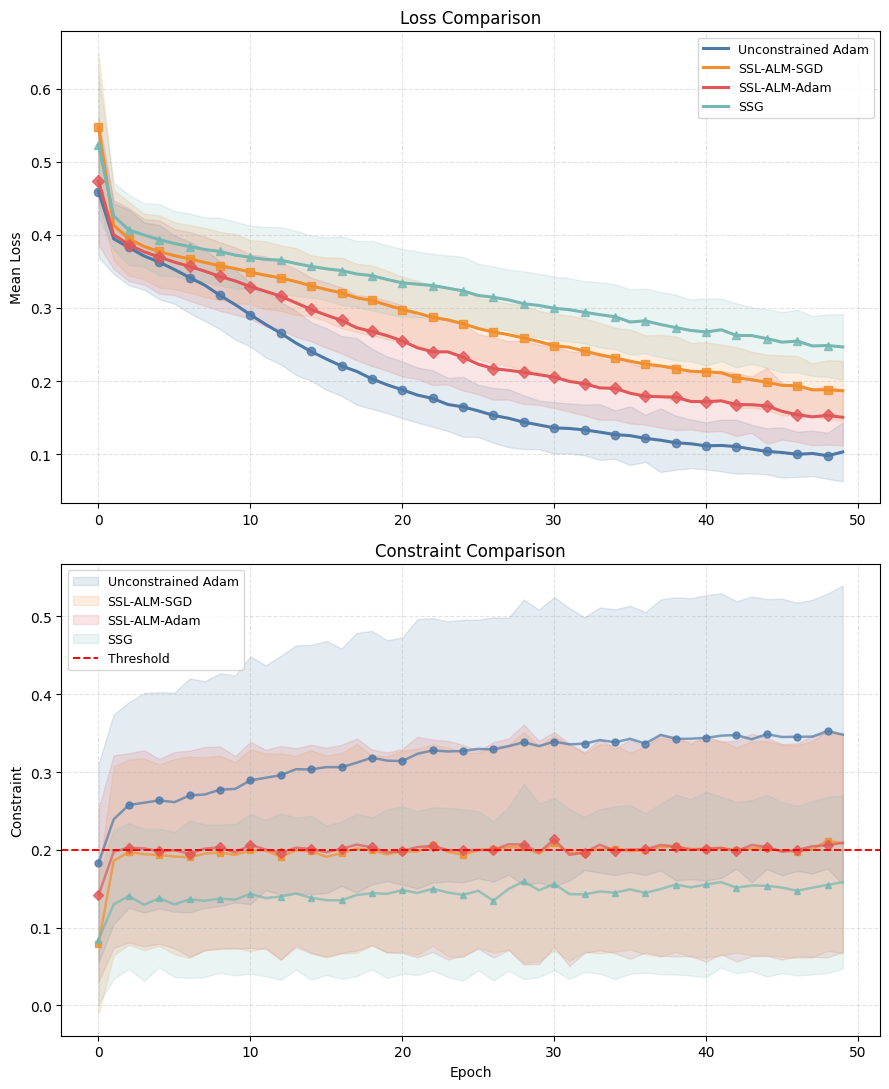

In [96]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
thresholds = [ fair_crit_bound ]

plot_losses_and_constraints_single_stochastic(losses, losses_std, constraints, constraints_std, thresholds, 
                                              titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam', "SSG"], 
                                              log_constraints=False, std_multiplier=1)

#### 4. Cooper - Augmented Lagrangian

In [97]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# get the dataset
dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

# create a balanced sampling - needed for an unbiased gradient
sampler = BalancedBatchSampler(
    subgroup_onehot=sens_train,
    batch_size=128,
    drop_last=True
)

# create a dataloader from the sampler
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

# define the criterion
criterion = torch.nn.BCEWithLogitsLoss()
statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [98]:
import torch
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [99]:
import cooper

# select device
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # define GPU if available
DEVICE = "cpu"

# define the problem
class ACS_Deterministic_Constr_Fair_ALM(cooper.ConstrainedMinimizationProblem):
    def __init__(self, formulation_type):
        super().__init__()

        # define the number of multipliers - same as the number of constraints
        if not formulation_type.expects_multiplier:
            self.multiplier = None
        else:
            self.multiplier = cooper.multipliers.DenseMultiplier(num_constraints=1, device=DEVICE) 

        # add the penalty coefficient - augmented lagrangian
        if not formulation_type.expects_penalty_coefficient:
            self.penalty = None
        else:
            self.penalty = cooper.penalty_coefficients.DensePenaltyCoefficient(
                init=torch.tensor(1.0, device=DEVICE),
            )
        
        # inequality constraints on the norm of the matrix
        self.constraint = cooper.Constraint(
            constraint_type=cooper.ConstraintType.INEQUALITY,
            formulation_type=formulation_type,
            multiplier=self.multiplier,
            penalty_coefficient=self.penalty,
        )


    # function that computes the constraints and the loss function
    def compute_cmp_state(self, model, inputs, targets, batch_sens):

        # compute the yhat loss
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        out = model(inputs)
        loss = criterion( out , targets )

        # compute fair metric
        fair_loss = fair_criterion(out, batch_sens)
        fair_constraint = fair_loss - fair_crit_bound
        
        # compute the constraint violation
        constraint_state = cooper.ConstraintState(violation=fair_constraint)
        observed_constraints = {self.constraint: constraint_state}

        return cooper.CMPState(loss=loss, observed_constraints=observed_constraints)


In [100]:
# create the problem
problem = ACS_Deterministic_Constr_Fair_ALM(cooper.formulations.AugmentedLagrangian)

# flag of dual variables
has_dual_variables = problem.multiplier is not None

# create the primal optimizer
primal_optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# create the dual optimizer
if has_dual_variables:
    dual_optimizer = torch.optim.SGD(problem.dual_parameters(), lr=0.05, maximize=True)

    # combine the optimizers
    constrained_optimizer = cooper.optim.SimultaneousOptimizer(
        cmp=problem,
        primal_optimizers=primal_optimizer,
        dual_optimizers=dual_optimizer,
    )
else:
    # Formulations without dual variables, such as the Quadratic Penalty
    # formulation, do not require a dual optimizer
    constrained_optimizer = cooper.optim.UnconstrainedOptimizer(
        cmp=problem,
        primal_optimizers=primal_optimizer,
    )

# Increase the penalty coefficient by `increment` if the constraint is violate by more
# than `violation_tolerance`- keep this the same - since its not included in SSL-ALM implementation
penalty_scheduler = cooper.penalty_coefficients.AdditivePenaltyCoefficientUpdater(
    increment=0.0, 
    violation_tolerance=1e-3,
)

In [101]:
# alloc arrays for plotting
Cooper_S_c_log_plotting    = []
Cooper_S_loss_log_plotting = []
Cooper_S_loss_std_log_plotting = []
Cooper_S_c_std_log_plotting = []

# training loop
for epoch in range(n_epochs):

    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []
    penalty_coefficient_values = []

    # alloc norm values array
    norm_values_c = []

    # go through all data
    for batch_input, batch_sens, batch_label in dataloader:

        # calculate the constraints - for logging purposes
        out = model(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        fair_constraint = fair_loss - fair_crit_bound
        c_log.append([fair_loss.detach().item()])

        # compute the loss - just for logging purposes
        loss = criterion( out , batch_label )
        loss_log.append(loss.item())

        # compute the states
        compute_cmp_state_kwargs = {"model": model, "inputs": batch_input, 
                                    "targets": batch_label, "batch_sens": batch_sens}
        roll_out = constrained_optimizer.roll(compute_cmp_state_kwargs=compute_cmp_state_kwargs)

        # Update the penalty coefficient
        constraint_state = roll_out.cmp_state.observed_constraints[problem.constraint]
        penalty_scheduler.update_penalty_coefficient_(problem.constraint, constraint_state)

        # get the dual variables and the coefficients
        multiplier_value = problem.multiplier.weight.detach().numpy() if has_dual_variables else None
        penalty_coefficient_value = problem.constraint.penalty_coefficient().item()

        # save the duals and penalty coefficients
        duals_log.append(multiplier_value)
        penalty_coefficient_values.append(penalty_coefficient_value)

    # save the epoch values for plotting
    Cooper_S_loss_log_plotting.append(np.mean(loss_log))
    Cooper_S_c_log_plotting.append(np.mean(c_log, axis=0))
    Cooper_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    Cooper_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}, "
        f"penalty coefficients: {np.mean(penalty_coefficient_values, axis=0)}, "
    )
    

Epoch: 0, loss: 0.4444855982236725, constraints: [0.17635845], dual: [0.0078749], penalty coefficients: 1.0, 
Epoch: 1, loss: 0.40838247044480963, constraints: [0.19060089], dual: [0.01945601], penalty coefficients: 1.0, 
Epoch: 2, loss: 0.39648603717629, constraints: [0.19798113], dual: [0.02770164], penalty coefficients: 1.0, 
Epoch: 3, loss: 0.3840197484484679, constraints: [0.19759223], dual: [0.038512], penalty coefficients: 1.0, 
Epoch: 4, loss: 0.37782849510796634, constraints: [0.18990761], dual: [0.04529574], penalty coefficients: 1.0, 
Epoch: 5, loss: 0.3691690169114003, constraints: [0.19361369], dual: [0.01884324], penalty coefficients: 1.0, 
Epoch: 6, loss: 0.3609591740176832, constraints: [0.19451166], dual: [0.04921701], penalty coefficients: 1.0, 
Epoch: 7, loss: 0.35403930722809523, constraints: [0.19934679], dual: [0.04334942], penalty coefficients: 1.0, 
Epoch: 8, loss: 0.3472038838181564, constraints: [0.19997339], dual: [0.04681811], penalty coefficients: 1.0, 
Epo

In [102]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"]) 
constraints_std = list(np.load(log_path)["constraints_std"]) 

# append
losses += [np.array(Cooper_S_loss_log_plotting)]
constraints += [np.array(Cooper_S_c_log_plotting).T]
losses_std += [np.array(Cooper_S_loss_std_log_plotting)]
constraints_std += [np.array(Cooper_S_c_std_log_plotting).T]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std, constraints_std=constraints_std)

#### Results

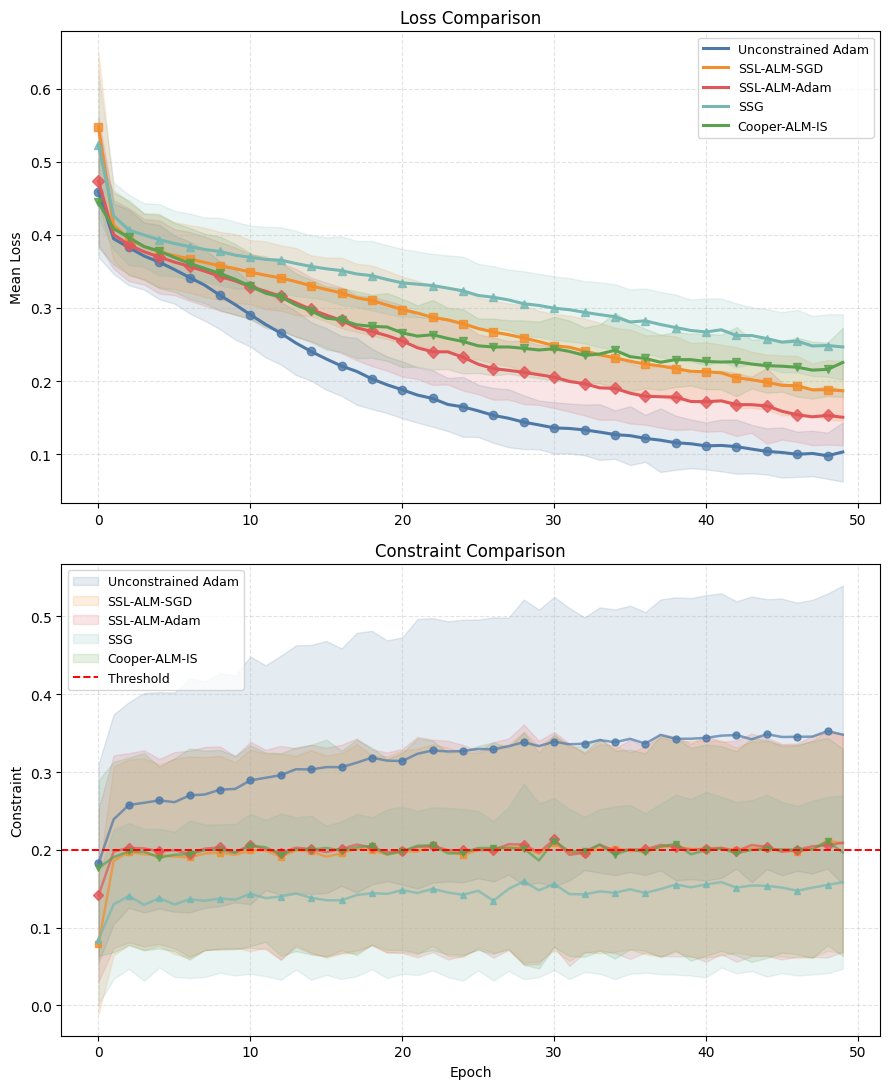

In [103]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
thresholds = [ fair_crit_bound ]

plot_losses_and_constraints_single_stochastic(losses, losses_std, constraints, constraints_std, thresholds, 
                                              titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam', "SSG", "Cooper-ALM-IS"], 
                                              log_constraints=False, std_multiplier=1)